In [2]:
import numpy as np
from scipy.stats import norm, entropy, wasserstein_distance

import xarray as xr
import numpy as np
import datetime
import time
import cartopy

import xarray as xr
import numpy as np
import matplotlib
import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.widgets import Slider
import cartopy
import random
import cf_xarray as cfxr
import pandas as pd
plt.rcParams.update({'font.size': 18})  

In [53]:
base_path = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/DE-Hai_51.08_10.45_v0.zarr"
# /Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-03_13:58:39_full_fluxnet/EVI_EN/DE-Hai_51.08_10.45_v0.zarr
def load_and_decode(sub_path, var_name):
    ds = xr.open_zarr(f"{base_path}/{sub_path}.zarr")
    return cfxr.decode_compress_to_multi_index(ds, "location")[var_name]

eco_cluster = load_and_decode("eco_clusters", "eco_clusters")
# deseasonalized = load_and_decode("deseasonalized", "deseasonalized")

base_path_modis =  "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_13:17:58_full_fluxnet_therightone_highveg_modis/EVI_MODIS/DE-Hai_51.08_10.45_v0.zarr/deseasonalized.zarr"
deseasonalized_modis = xr.open_zarr(base_path_modis)
deseasonalized_modis = cfxr.decode_compress_to_multi_index(deseasonalized_modis, "location").deseasonalized

In [149]:
single_eco_cluster = eco_cluster.isel(location=20)
eco_cluster_value = (single_eco_cluster.sel(component=0).values.item(), single_eco_cluster.sel(component=1).values.item(), single_eco_cluster.sel(component=2).values.item())
data_modis = deseasonalized_modis.isel(location=20)

In [54]:
path_clsrs = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/eco_clusters.zarr"
ds = xr.open_zarr(path_clsrs)
eco_cluster_training = cfxr.decode_compress_to_multi_index(ds, "location").eco_clusters

path_clsrs = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/deseasonalized.zarr"
ds = xr.open_zarr(path_clsrs)
deseasonalized_training = cfxr.decode_compress_to_multi_index(ds, "location").deseasonalized

# Plot all the location in the same eco_cluster
# Compare the entire dataset to find matching locations
single_eco_cluster = eco_cluster.isel(location=20)
eco_cluster_value = (single_eco_cluster.sel(component=0).values.item(), single_eco_cluster.sel(component=1).values.item(), single_eco_cluster.sel(component=2).values.item())
matching_mask = (eco_cluster_training.sel(component=0).values == eco_cluster_value[0]) & \
                (eco_cluster_training.sel(component=1).values == eco_cluster_value[1]) & \
                (eco_cluster_training.sel(component=2).values == eco_cluster_value[2])

# Extract the locations where all components match
single_cluster = eco_cluster_training[matching_mask]
data_cluster = deseasonalized_training.sel(location=single_cluster.location)

In [178]:
def _create_cluster_labels(eco_clusters):
    """Create cluster labels for grouping."""
    unique_clusters, _ = np.unique(
        eco_clusters.values, axis=0, return_counts=True
    )
    labels = xr.DataArray(
        data=np.argmax(
            np.all(
                eco_clusters.values[:, :, None]
                == unique_clusters.T[None, :, :],
                axis=1,
            ),
            axis=1,
        ),
        dims=("location",),
        coords={"location": eco_clusters.location},
    )
    return unique_clusters, labels

unique_clusters, eco_cluster_labels = _create_cluster_labels(eco_cluster_training)
mean_s2 = deseasonalized_training.groupby(eco_cluster_labels).mean(dim=["location", "time"])
std_s2 = deseasonalized_training.groupby(eco_cluster_labels).std(dim=["location", "time"])

# Get the mean and variance of each unique eco-cluster in eco_cluster from the training data
def match_test_to_training_clusters(eco_cluster_test, unique_clusters):
    # Find which training cluster each test location matches
    matched_labels = np.argmax(
        np.all(
            eco_cluster_test.values[:, :, None] == unique_clusters.T[None, :, :],
            axis=1,
        ),
        axis=1,
    )
    return xr.DataArray(
        data=matched_labels,
        dims=("location",),
        coords={"location": eco_cluster_test.location},
    )
eco_cluster_test_labels = match_test_to_training_clusters(eco_cluster, unique_clusters)

mean_for_test = mean_s2.sel(group=eco_cluster_test_labels)
std_for_test = std_s2.sel(group=eco_cluster_test_labels)

In [213]:
# Calculate mean and variance for each modis pixel
mean_modis = deseasonalized_modis.mean(dim="time")
std_modis = deseasonalized_modis.var(dim="time")

In [55]:
def _create_cluster_labels(eco_clusters):
    """Create cluster labels for grouping."""
    unique_clusters, _ = np.unique(
        eco_clusters.values, axis=0, return_counts=True
    )
    labels = xr.DataArray(
        data=np.argmax(
            np.all(
                eco_clusters.values[:, :, None]
                == unique_clusters.T[None, :, :],
                axis=1,
            ),
            axis=1,
        ),
        dims=("location",),
        coords={"location": eco_clusters.location},
    )
    return unique_clusters, labels

unique_clusters, eco_cluster_labels = _create_cluster_labels(eco_cluster_training)
deseasonalized_with_labels = deseasonalized_training.assign_coords(
    group=eco_cluster_labels
)

# Get the mean and variance of each unique eco-cluster in eco_cluster from the training data
def match_test_to_training_clusters(eco_cluster_test, unique_clusters):
    # Find which training cluster each test location matches
    matched_labels = np.argmax(
        np.all(
            eco_cluster_test.values[:, :, None] == unique_clusters.T[None, :, :],
            axis=1,
        ),
        axis=1,
    )
    return xr.DataArray(
        data=matched_labels,
        dims=("location",),
        coords={"location": eco_cluster_test.location},
    )
eco_cluster_test_labels = match_test_to_training_clusters(eco_cluster, unique_clusters)
unique_clusters, _ = np.unique(
        eco_cluster.values, axis=0, return_counts=True
    )

# Get the group (eco-cluster) labels for the training set
train_group_labels = deseasonalized_with_labels.group.values
test_unique_clusters = np.unique(eco_cluster_test_labels.values)

# Create a mask that keeps only the locations in the training data where the eco-cluster is in the test set
mask = np.isin(train_group_labels, test_unique_clusters)

# Apply the mask to filter the deseasonalized training data
eco_clusters_distribution = {}
for group_val, group_da in deseasonalized_with_labels.sel(location=mask).groupby("group"):
    if isinstance(group_da.indexes.get("location"), pd.MultiIndex):
        group_da = group_da.reset_index("location")

    flattened = group_da.data.flatten()
    eco_clusters_distribution[group_val] = flattened

#eco_cluster_labels.groupby(eco_cluster_labels).map(lambda x: eco_clusters_distribution[x.group])
#eco_cluster.groupby(eco_cluster_labels).map(lambda x: eco_clusters_distribution[]

# Get the group label for each location
test_labels = eco_cluster_labels.values

# Map each location to its corresponding distribution
mapped_distributions = [
    eco_clusters_distribution[label] for label in test_labels if label in eco_clusters_distribution
]


In [159]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
        """
        KL divergence between two univariate Gaussians: P || Q
        """
        return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5


results = kl_divergence_gaussians(
    mu_p=mean_modis,
    sigma_p=std_modis,
    mu_q=mean_for_test,
    sigma_q=std_for_test,)


In [189]:
def _create_cluster_labels(eco_clusters):
    """Create cluster labels for grouping."""
    unique_clusters, _ = np.unique(
        eco_clusters.values, axis=0, return_counts=True
    )
    labels = xr.DataArray(
        data=np.argmax(
            np.all(
                eco_clusters.values[:, :, None]
                == unique_clusters.T[None, :, :],
                axis=1,
            ),
            axis=1,
        ),
        dims=("location",),
        coords={"location": eco_clusters.location},
    )
    return unique_clusters, labels

unique_clusters, eco_cluster_labels = _create_cluster_labels(eco_cluster_training)
# Step 2: Create a new variable with group labels
deseasonalized_with_labels = deseasonalized_training.assign_coords(
    group=eco_cluster_labels
)
# Step 3: For each group, flatten the location and time dimensions into a single dimension
aggregated_distributions = {}
for cluster_id in range(len(unique_clusters)):
    cluster_data = deseasonalized_with_labels.where(
        eco_cluster_labels == cluster_id, drop=True
    )
    if isinstance(cluster_data.indexes.get("location"), pd.MultiIndex):
        cluster_data = cluster_data.reset_index("location")

    # Stack location and time into one dimension
    flattened = cluster_data.stack(sample=("location", "time")).dropna("sample")
    # Stack location and time into a single dimension
    #flattened = cluster_data.stack(location_time=("location", "time"))
    aggregated_distributions[cluster_id] = flattened

# Optional: turn into a single xarray object
eco_cluster_distributions = xr.concat(
    [aggregated_distributions[k] for k in sorted(aggregated_distributions)],
    dim="group"
)
eco_cluster_distributions = eco_cluster_distributions.assign_coords(
    group=("group", list(sorted(aggregated_distributions)))
)

# Get the mean and variance of each unique eco-cluster in eco_cluster from the training data
def match_test_to_training_clusters(eco_cluster_test, unique_clusters):
    # Find which training cluster each test location matches
    matched_labels = np.argmax(
        np.all(
            eco_cluster_test.values[:, :, None] == unique_clusters.T[None, :, :],
            axis=1,
        ),
        axis=1,
    )
    return xr.DataArray(
        data=matched_labels,
        dims=("location",),
        coords={"location": eco_cluster_test.location},
    )
eco_cluster_test_labels = match_test_to_training_clusters(eco_cluster, unique_clusters)

mean_for_test = mean_s2.sel(group=eco_cluster_test_labels)
std_for_test = std_s2.sel(group=eco_cluster_test_labels)

KeyboardInterrupt: 

In [ ]:
from scipy.stats import gaussian_kde
import dask
from dask import delayed

def kde_kl_divergence(samples_P, samples_Q, num_points=1000, epsilon=1e-10):
    samples_P = samples_P[np.isfinite(samples_P)]
    samples_Q = samples_Q[np.isfinite(samples_Q)]
    # Step 1: Estimate KDE for each distribution
    kde_P = gaussian_kde(samples_P)
    kde_Q = gaussian_kde(samples_Q)

    # Step 2: Create a shared evaluation grid over the range of both distributions
    min_val = min(np.min(samples_P), np.min(samples_Q))
    max_val = max(np.max(samples_P), np.max(samples_Q))
    grid = np.linspace(min_val, max_val, num_points)

    # Step 3: Evaluate both KDEs on the grid
    P_vals = kde_P(grid)
    Q_vals = kde_Q(grid)

    # Step 4: Normalize to make sure they sum to 1 (optional, but cleaner for discrete KL)
    P_vals /= np.sum(P_vals)
    Q_vals /= np.sum(Q_vals)

    # Step 5: Compute KL divergence (add epsilon to avoid log(0))
    P_vals = np.clip(P_vals, epsilon, 1)
    Q_vals = np.clip(Q_vals, epsilon, 1)
    
    kl_div = np.sum(P_vals * np.log(P_vals / Q_vals))

    return kl_div

@delayed
def compute_kl(location):
    group_label = eco_cluster_test_labels.sel(location=location).values.item()
    test_data = deseasonalized_modis.sel(location=location).values
    ref_distribution = eco_clusters_distribution[group_label]
    return kde_kl_divergence(test_data, ref_distribution)

# Create delayed tasks for each location
locations = eco_cluster_test_labels.location.values #[:10]
tasks = [compute_kl(loc) for loc in locations]

# Trigger the computation
results_list = dask.compute(*tasks)
results_xr = xr.DataArray(
        np.full(
            (len(locations),),
            np.nan,
        ),
        dims=["location"],
        coords={
            "location": locations,
        },
    )
print("xr in progrss")
# Populate your results DataArray
for i, loc in enumerate(locations):
    results_xr.loc[dict(location=loc)] = results_list[i]

In [78]:
from scipy.stats import gaussian_kde
import numpy as np
import xarray as xr
from dask import delayed, compute

# Precompute KDEs for each cluster and store
reference_kdes = {
    label: gaussian_kde(ref_vals[np.isfinite(ref_vals)])
    for label, ref_vals in eco_clusters_distribution.items()
}

# Step 3: Find unique time series
unique_ts_modis = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(lambda x: x.mean(dim="location")).transpose("deseasonalized", "time").values
# Step 4: Compute KDEs for each unique time series
kdes_modis = {}
for loc in range(unique_ts_modis.shape[0]):
    series = unique_ts_modis[loc, :]
    # Step 2: Remove rows with any NaNs
    series = series[np.isfinite(series)]
    kdes_modis[np.round(np.nanmean(series), 10)] = gaussian_kde(series)


def fast_kl_divergence(test_kde, ref_kde, grid, epsilon=1e-10):
    P_vals = test_kde(grid)
    Q_vals = ref_kde(grid)

    # Clip to avoid log(0)
    P_vals = np.clip(P_vals, epsilon, None)
    Q_vals = np.clip(Q_vals, epsilon, None)
    
    return np.sum(P_vals * np.log(P_vals / Q_vals))

# @delayed
def compute_kl(location):
    group_label = eco_cluster_test_labels.sel(location=location).values.item()
    test_data = deseasonalized_modis.sel(location=location).values
    ref_kde = reference_kdes[group_label]

    test_data = test_data[np.isfinite(test_data)]
    test_kde = kdes_modis[np.round(np.nanmean(test_data), 10)]

    min_val, max_val = np.min(test_data), np.max(test_data)
    grid = np.linspace(min_val, max_val, 100)
    return fast_kl_divergence(test_kde, ref_kde, grid)

locations = eco_cluster_test_labels.location.values[0:20]
tasks = [compute_kl(loc) for loc in locations]
results_list = compute(*tasks)

# Create the results DataArray
results_xr = xr.DataArray(np.array(results_list), dims=["location"], coords={"location": locations})

In [71]:
results_xr.values

array([14.46991252, 16.17668484, 21.81517757, 16.17668484, 16.17668484,
       16.17668484, 21.81517757,  9.27935127,  8.49426168,  7.05419125,
        7.05419125,  7.05419125,  6.47175916,  6.47175916,  6.47175916,
        6.47175916,  7.05419125,  7.05419125,  7.05419125,  6.47175916])

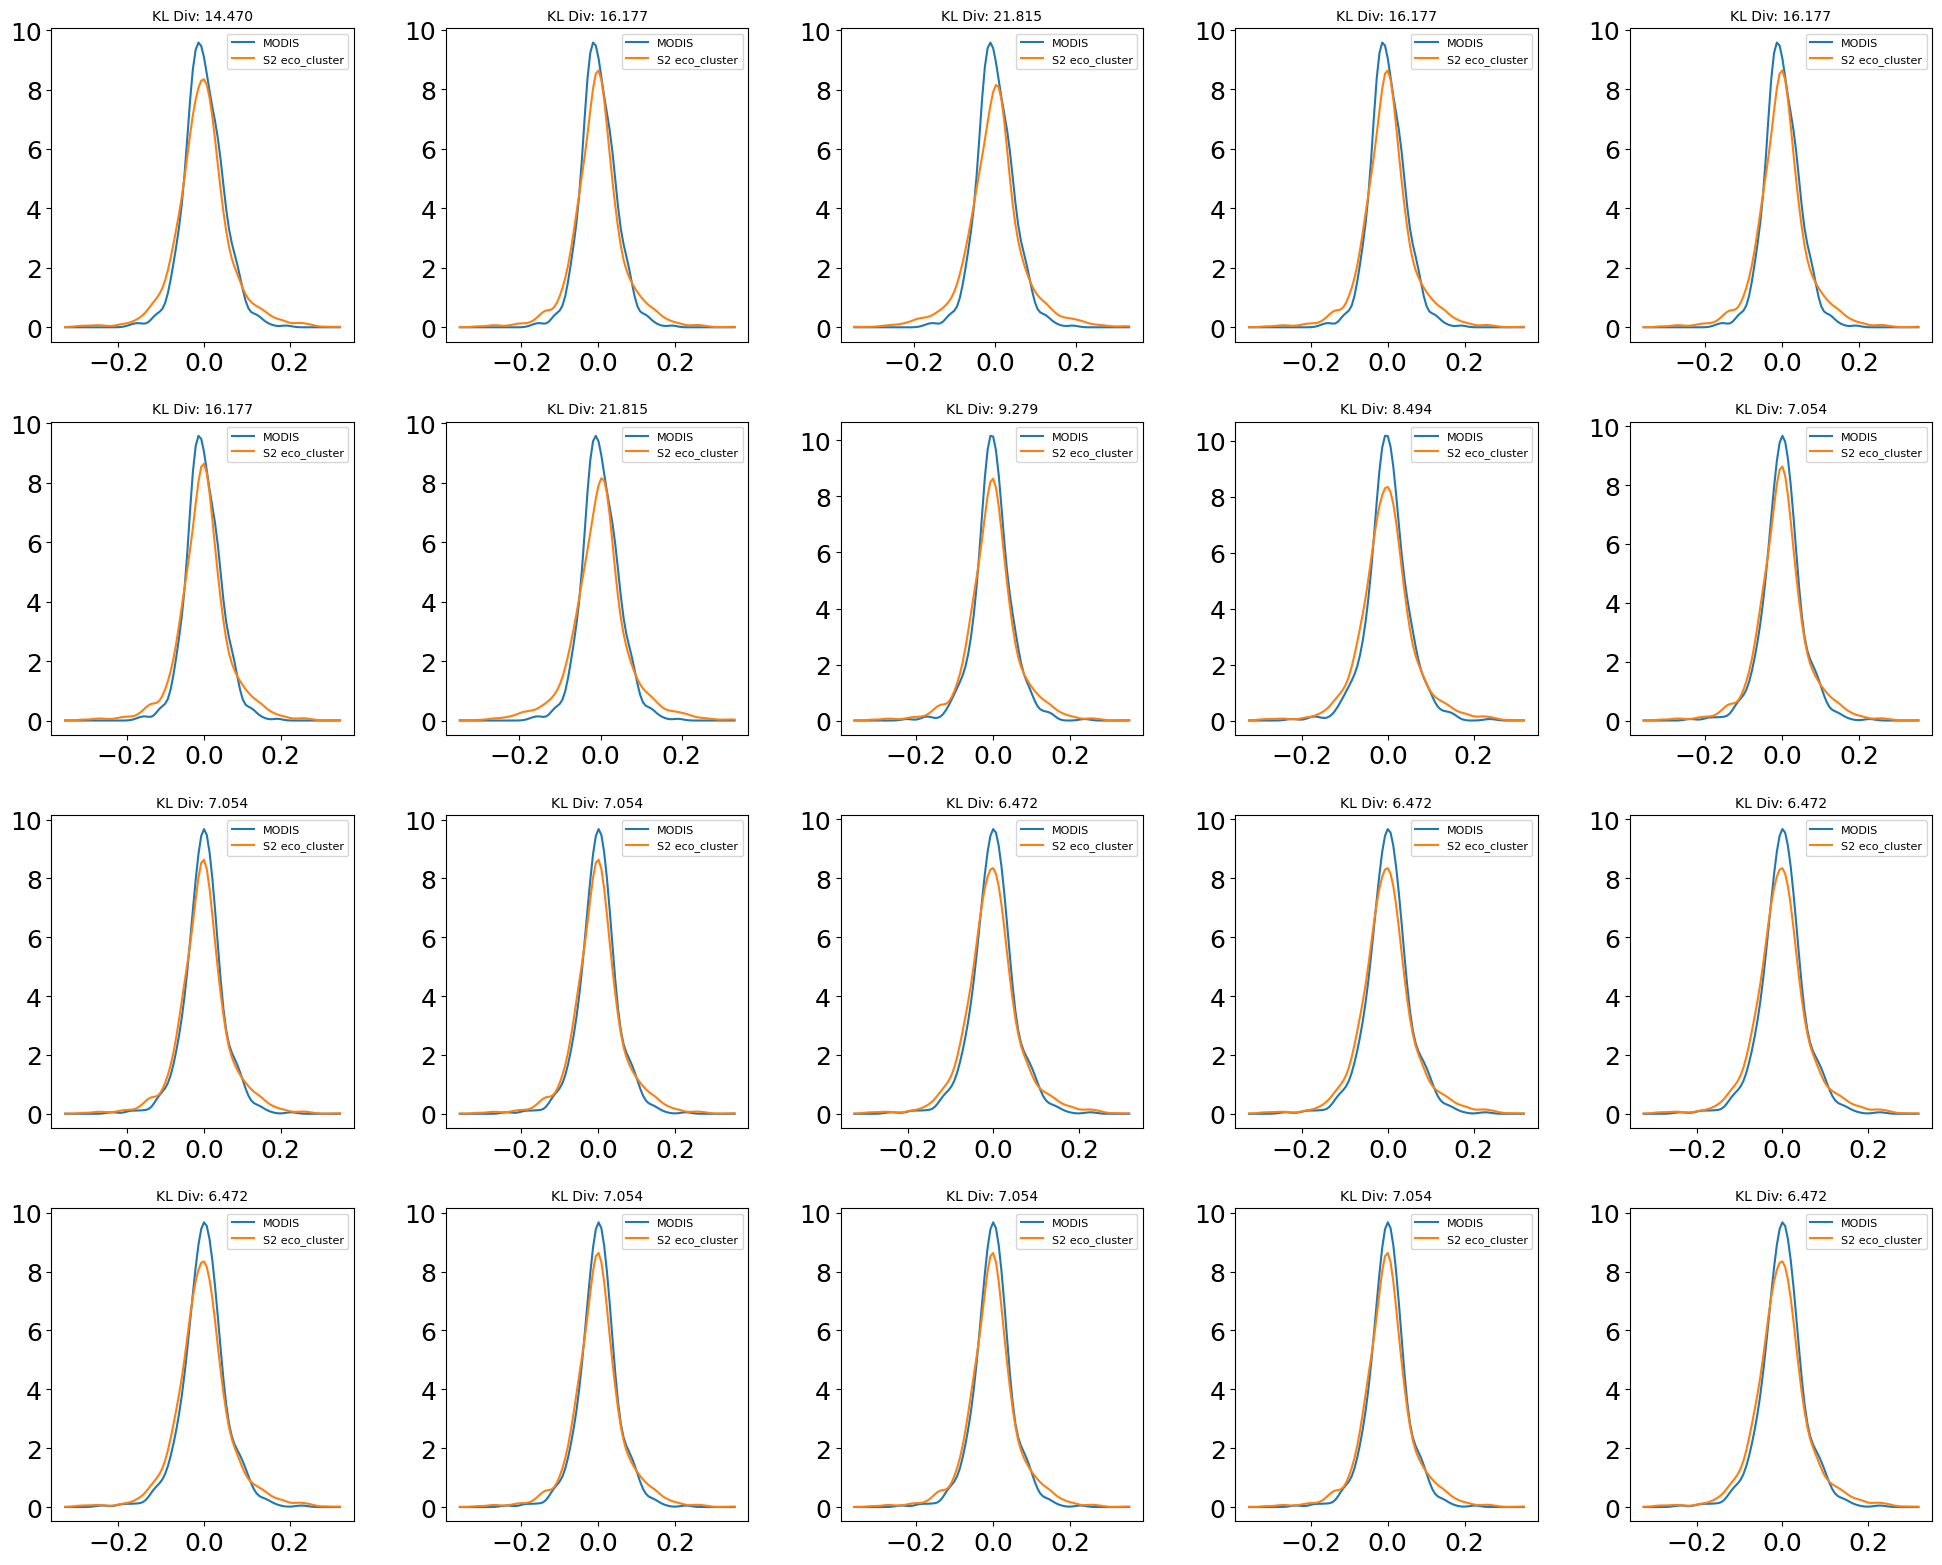

In [79]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # 4 rows, 5 columns
axes = axes.flatten()  # Flatten to make indexing easier

for location in range(20):
    group_label = eco_cluster_test_labels.isel(location=location).values.item()
    s2_data = eco_clusters_distribution[group_label]
    test_data = deseasonalized_modis.isel(location=location).values
    
    ref_kde = reference_kdes[group_label]
    test_data = test_data[np.isfinite(test_data)]
    test_kde = kdes_modis[np.round(np.nanmean(test_data), 10)]
    
    min_val, max_val = min(np.min(test_data), np.nanmin(s2_data)), max(np.max(test_data), np.nanmax(s2_data))
    grid = np.linspace(min_val, max_val, 100)
    
    ax = axes[location]
    ax.plot(grid, test_kde(grid), label="MODIS")
    ax.plot(grid, ref_kde(grid), label="S2 eco_cluster")

    ax.set_title(f"KL Div: {results_xr.values[location]:.3f}", fontsize=10)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


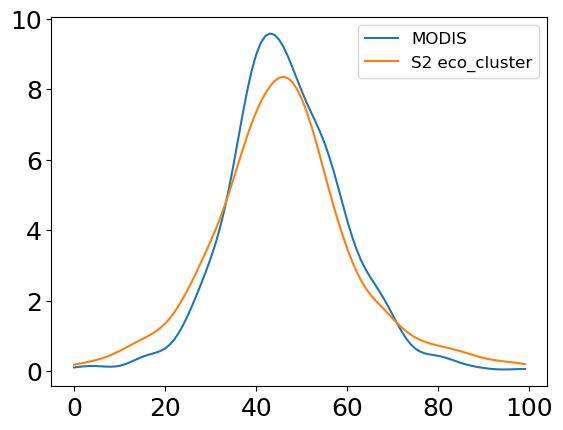

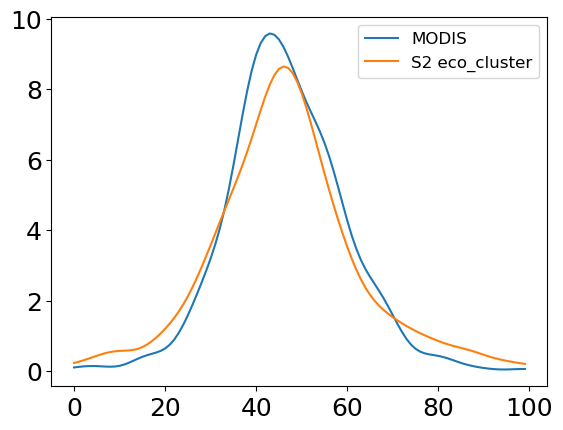

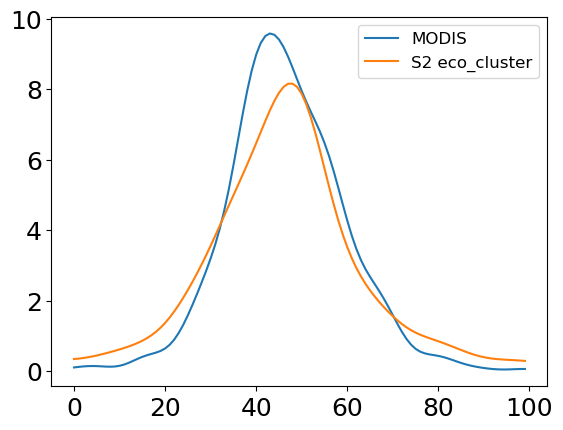

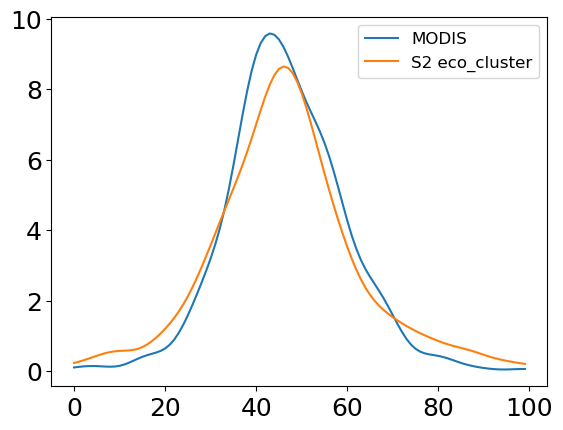

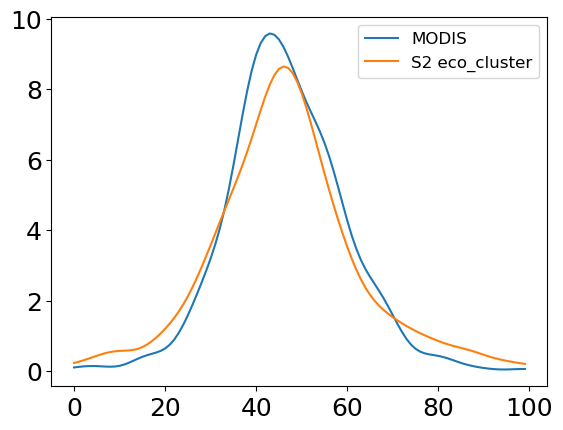

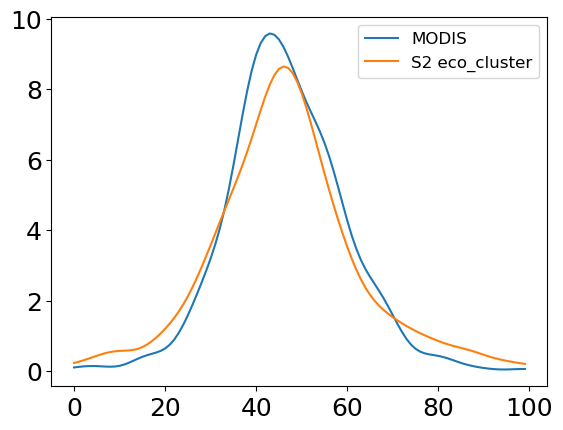

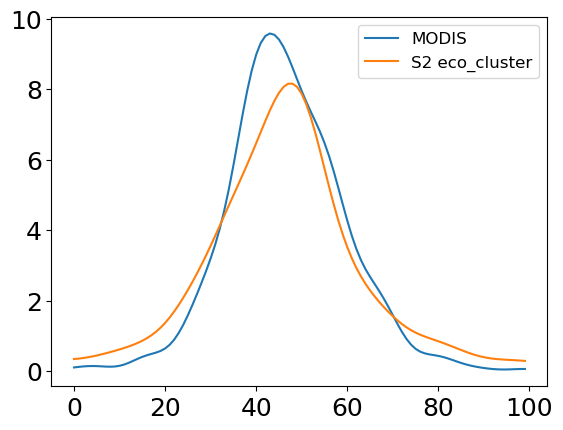

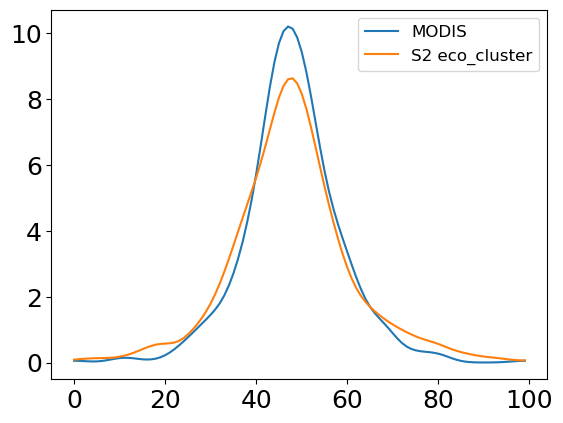

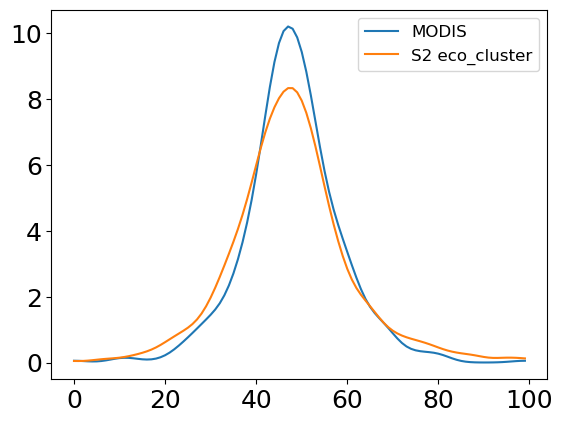

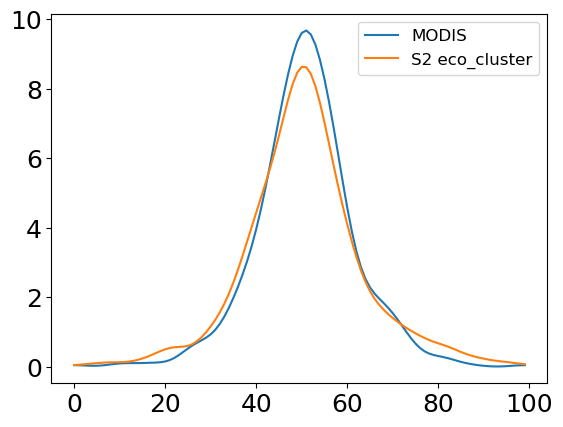

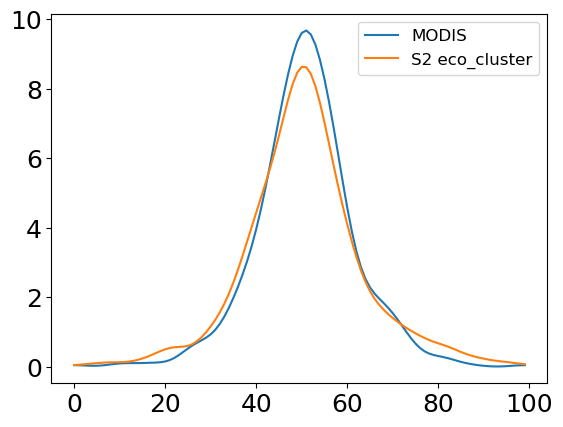

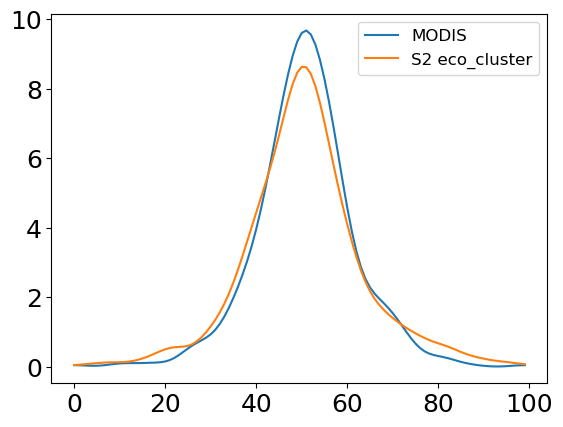

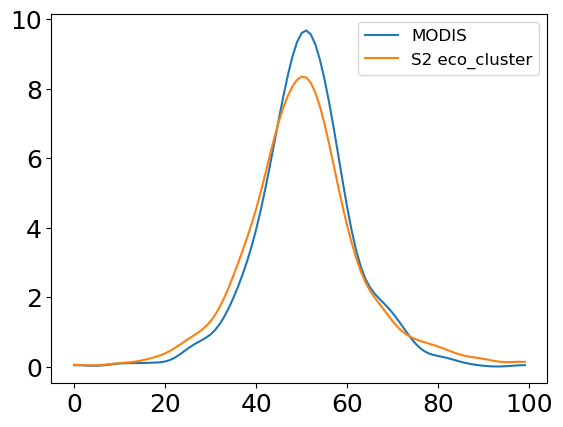

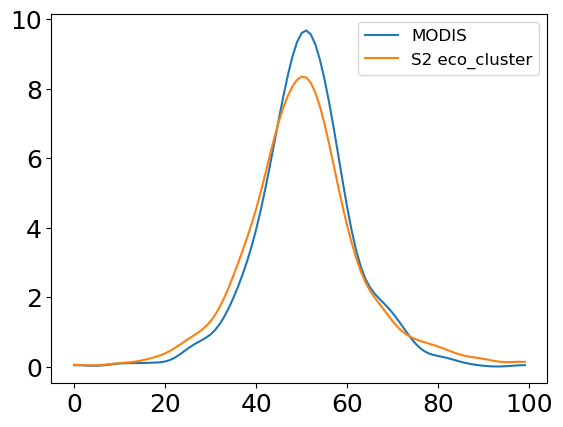

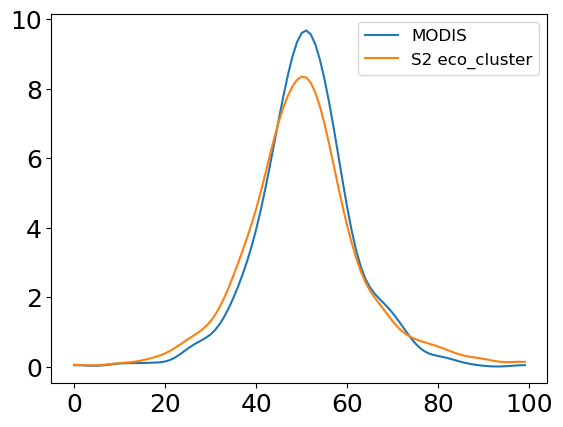

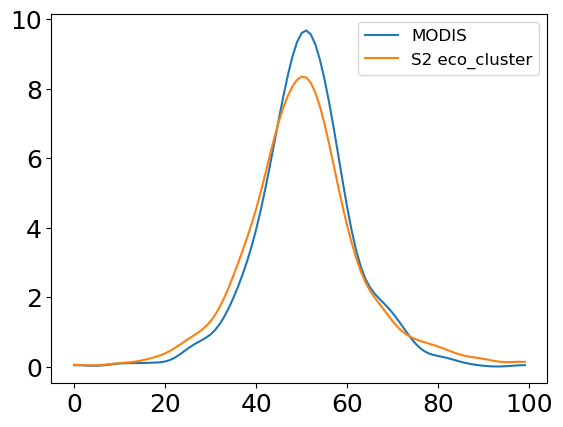

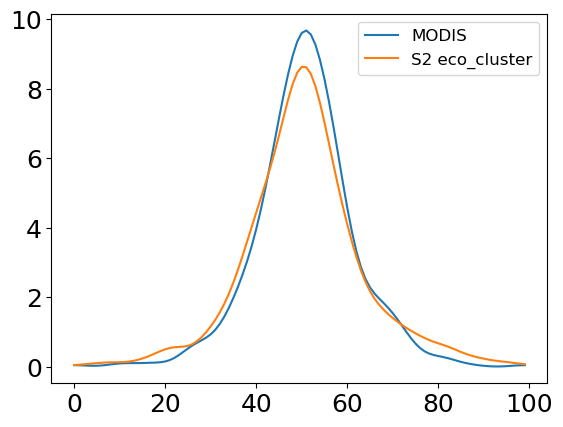

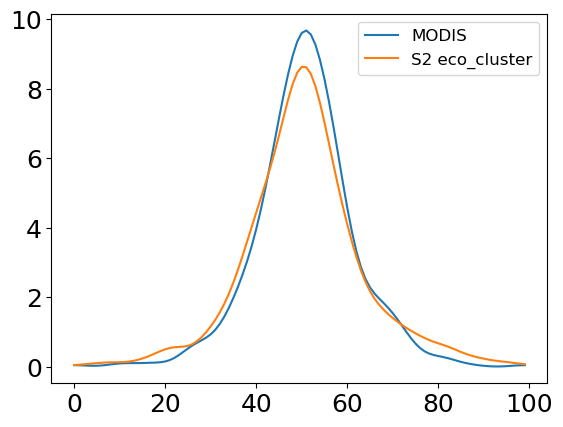

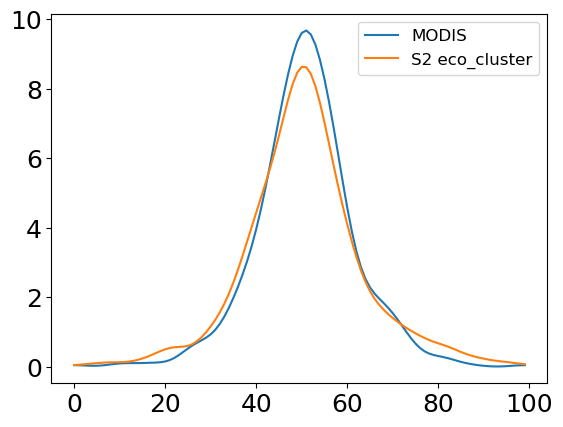

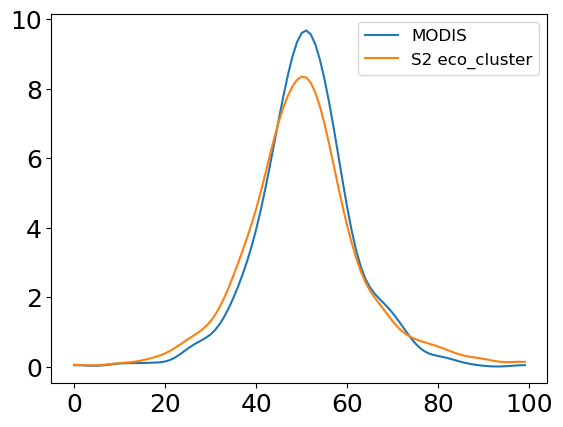

In [72]:
for location in range(0, 20):
    group_label = eco_cluster_test_labels.isel(location=location).values.item()
    test_data = deseasonalized_modis.isel(location=location).values
    
    ref_kde = reference_kdes[group_label]
    test_data = test_data[np.isfinite(test_data)]
    test_kde = kdes_modis[np.round(np.nanmean(test_data), 10)]
    min_val, max_val = np.min(test_data), np.max(test_data)
    grid = np.linspace(min_val, max_val, 100)
    
    fig, ax = plt.subplots()
    ax.plot(test_kde(grid), label="MODIS")
    ax.plot(ref_kde(grid), label="S2 eco_cluster")
    ax.legend(fontsize=12)
    plt.show()

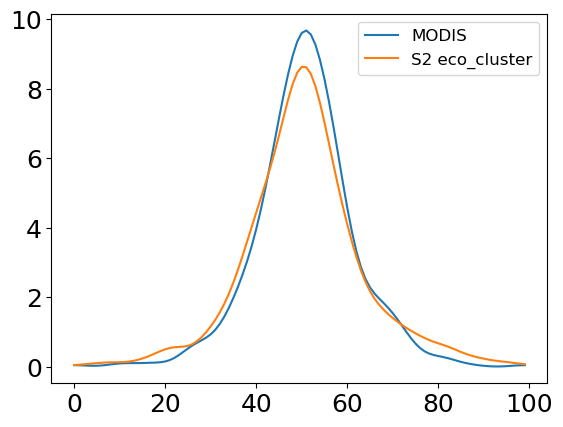

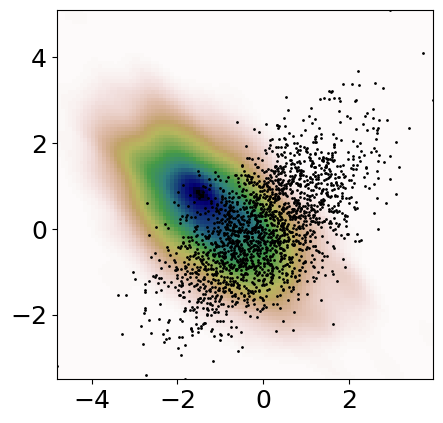

In [38]:
import numpy as np

from scipy import stats

def measure(n):

    "Measurement model, return two coupled measurements."

    m1 = np.random.normal(size=n)

    m2 = np.random.normal(scale=0.5, size=n)

    return m1+m2, m1-m2

m1, m2 = measure(2000)

xmin = m1.min()

xmax = m1.max()

ymin = m2.min()

ymax = m2.max()


X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([m1, m2])

kernel = stats.gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)


import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.imshow(Z, cmap=plt.cm.gist_earth_r,

          extent=[xmin, xmax, ymin, ymax])

ax.plot(m1, m2, 'k.', markersize=2)

ax.set_xlim([xmin, xmax])

ax.set_ylim([ymin, ymax])

plt.show()

In [34]:
results_xr.values

array([10.69499005, 13.06956873, 24.52097925, 24.52097925, 30.04516336,
       24.52097925, 12.76975551, 12.73645432, 12.76975551, 13.06956873,
       16.99005155, 14.39903496, 11.38845217,  7.75892978,  8.25263642,
        7.1436298 ,  7.1436298 ,  8.25263642,  7.1436298 ,  8.25263642])

In [24]:
# Plot the data and grab the figure and axes
plot = results_xr.unstack(dim="location").plot(vmin=0, vmax=4, cmap="Reds")

# Access the axes from the plot object
ax = plot.axes

# Remove x and y axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Remove title

# Update colorbar label
plot.colorbar.set_label('KL Divergence')

ValueError: cannot unstack dimensions that do not have exactly one multi-index: ('location',)

In [ ]:
from scipy.stats import gaussian_kde

import numpy as np
from scipy.stats import gaussian_kde
import xarray as xr


# Step 3: Find unique time series
data = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(lambda x: x.mean(dim="location")).transpose("deseasonalized", "time").values
# Step 4: Compute KDEs for each unique time series
kdes_modis = {}
for loc in range(data.shape[0]):
    series = data[loc, :]
    # Step 2: Remove rows with any NaNs
    series = series[np.isfinite(series)]
    kdes_modis[np.mean(series)] = gaussian_kde(series)

# (Optional) Map each original (cleaned) time series to its KDE
#mapped_kdes = [kdes[i] for i in inverse_indices]


In [15]:
def kde_modis_computation(x):
    series = x.mean(dim="location").values
    series =  series[np.isfinite(series)]
    return gaussian_kde(series)

# Step 3: Find unique time series
data = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(kde_modis_computation).transpose("deseasonalized", "time").values
# # Step 4: Compute KDEs for each unique time series
# kdes_modis = {}
# for loc in range(data.shape[0]):
#     series = data[loc, :]
#     # Step 2: Remove rows with any NaNs
#     series = series[np.isfinite(series)]
#     kdes_modis[np.mean(series)] = gaussian_kde(series)

AttributeError: 'gaussian_kde' object has no attribute 'dims'

In [10]:
data = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(lambda x: x.mean(dim="location")).transpose("deseasonalized", "time").values

In [11]:
data.shape

(136, 1086)

In [1]:
data = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(lambda x: x.mean(dim="location"))

NameError: name 'deseasonalized_modis' is not defined

In [36]:
unique_time_series, inverse_indices = np.unique(data, axis=0, return_inverse=True)

In [52]:
deseasonalized_modis

<xarray.DataArray 'deseasonalized' (time: 1086, location: 15876)> Size: 138MB
dask.array<open_dataset-deseasonalized, shape=(1086, 15876), dtype=float64, chunksize=(50, 15876), chunktype=numpy.ndarray>
Coordinates:
    source_path  <U86 344B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCubes...
  * time         (time) datetime64[ns] 9kB 2000-02-18 2000-03-05 ... 2025-01-01
  * location     (location) object 127kB MultiIndex
  * longitude    (location) float64 127kB 10.35 10.35 10.35 ... 10.38 10.38
  * latitude     (location) float64 127kB 51.34 51.34 51.34 ... 51.32 51.32

In [61]:
data = deseasonalized_modis.groupby(deseasonalized_modis.mean(dim="time")).map(lambda x: x.mean(dim="location"))

In [70]:
deseasonalized_modis.location.values#isel(location=0).values

array([(10.349661177336213, 51.339730582818916),
       (10.349661177336213, 51.33954748525546),
       (10.349661177336213, 51.339364387025185), ...,
       (10.384864267667947, 51.31720458324285),
       (10.384864267667947, 51.31702140375787),
       (10.384864267667947, 51.316838223607704)], dtype=object)

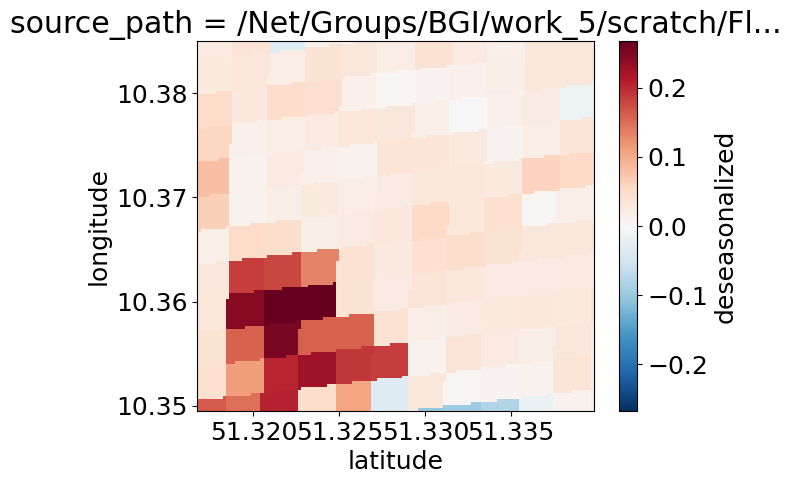

In [69]:
deseasonalized_modis.isel(time=1000).unstack("location").plot()

In [53]:
data = deseasonalized_modis.transpose("location", "time").values
series, indice = np.unique(data, axis=0, return_inverse=True)

In [57]:
series.shape

(15876, 1086)

In [51]:
deseasonalized_modis.mean(dim="location")

<xarray.DataArray 'deseasonalized' (time: 1086)> Size: 9kB
dask.array<mean_agg-aggregate, shape=(1086,), dtype=float64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
    source_path  <U86 344B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCubes...
  * time         (time) datetime64[ns] 9kB 2000-02-18 2000-03-05 ... 2025-01-01

In [20]:
gaussian_kde(deseasonalized_modis.isel(location=0)[np.isfinite(deseasonalized_modis.isel(location=0)).compute()].values)

In [22]:
deseasonalized_modis

<xarray.DataArray 'deseasonalized' (time: 1086, location: 15876)> Size: 138MB
dask.array<open_dataset-deseasonalized, shape=(1086, 15876), dtype=float64, chunksize=(50, 15876), chunktype=numpy.ndarray>
Coordinates:
    source_path  <U86 344B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCubes...
  * time         (time) datetime64[ns] 9kB 2000-02-18 2000-03-05 ... 2025-01-01
  * location     (location) object 127kB MultiIndex
  * longitude    (location) float64 127kB 10.35 10.35 10.35 ... 10.38 10.38
  * latitude     (location) float64 127kB 51.34 51.34 51.34 ... 51.32 51.32

In [274]:
for loc in eco_cluster_test_labels.location:
    print(loc)

<xarray.DataArray 'location' ()> Size: 8B
array((10.349661177336213, 51.339730582818916), dtype=object)
Coordinates:
    location   object 8B (10.349661177336213, 51.339730582818916)
    longitude  float64 8B 10.35
    latitude   float64 8B 51.34
<xarray.DataArray 'location' ()> Size: 8B
array((10.349661177336213, 51.33954748525546), dtype=object)
Coordinates:
    location   object 8B (10.349661177336213, 51.33954748525546)
    longitude  float64 8B 10.35
    latitude   float64 8B 51.34
<xarray.DataArray 'location' ()> Size: 8B
array((10.349661177336213, 51.339364387025185), dtype=object)
Coordinates:
    location   object 8B (10.349661177336213, 51.339364387025185)
    longitude  float64 8B 10.35
    latitude   float64 8B 51.34
<xarray.DataArray 'location' ()> Size: 8B
array((10.349661177336213, 51.33918128812807), dtype=object)
Coordinates:
    location   object 8B (10.349661177336213, 51.33918128812807)
    longitude  float64 8B 10.35
    latitude   float64 8B 51.34
<xarray.DataArra

KeyboardInterrupt: 

In [167]:
# Plot the data and grab the figure and axes
plot = results.unstack(dim="location").plot(vmin=0, vmax=4, cmap="Reds")

# Access the axes from the plot object
ax = plot.axes

# Remove x and y axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Remove title
ax.set_title('Leinefelde')

# Update colorbar label
plot.colorbar.set_label('KL Divergence')



AttributeError: 'numpy.float64' object has no attribute 'unstack'

In [ ]:
log =  np.log(mean_for_test / sigma_p)

<xarray.DataArray 'deseasonalized' (location: 14397)> Size: 115kB
dask.array<sub, shape=(14397,), dtype=float64, chunksize=(346,), chunktype=numpy.ndarray>
Coordinates:
    group        (location) int64 115kB 225 141 141 224 224 ... 205 178 178 178
  * location     (location) object 115kB MultiIndex
  * longitude    (location) float64 115kB 11.54 11.54 11.54 ... 11.57 11.57
  * latitude     (location) float64 115kB 50.91 50.91 50.91 ... 50.89 50.89
    source_path  <U88 352B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCubes...

In [102]:
mean_modis = mean_modis.sel(location=std_for_test.location)

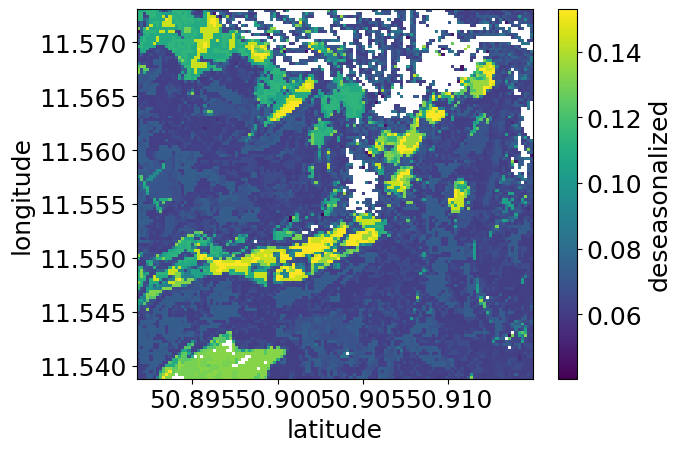

In [116]:
std_for_test.unstack(dim="location").plot()

In [11]:
mean_for_test

<xarray.DataArray 'deseasonalized' (time: 156, location: 15876)> Size: 20MB
dask.array<getitem, shape=(156, 15876), dtype=float64, chunksize=(50, 298), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1kB 2016-01-01 2016-01-17 ... 2022-09-30
    group      (location) int64 127kB 222 266 266 245 245 ... 205 181 181 181
  * location   (location) object 127kB MultiIndex
  * longitude  (location) float64 127kB 6.005e+05 6.005e+05 ... 6.03e+05
  * latitude   (location) float64 127kB 5.661e+06 5.661e+06 ... 5.658e+06

In [33]:
def match_test_to_training_clusters(eco_cluster_test, unique_clusters):
    # Find which training cluster each test location matches
    matched_labels = np.argmax(
        np.all(
            eco_cluster_test.values[:, :, None] == unique_clusters.T[None, :, :],
            axis=1,
        ),
        axis=1,
    )
    return xr.DataArray(
        data=matched_labels,
        dims=("location",),
        coords={"location": eco_cluster_test.location},
    )

eco_cluster_test_labels = match_test_to_training_clusters(eco_cluster, unique_clusters)

In [35]:
mean_for_test = mean_s2.sel(group=eco_cluster_test_labels)
std_for_test = std_s2.sel(group=eco_cluster_test_labels)


NameError: name 'std_s2' is not defined

In [36]:
mean_for_test

<xarray.DataArray 'deseasonalized' (time: 156, location: 15876)> Size: 20MB
dask.array<getitem, shape=(156, 15876), dtype=float64, chunksize=(50, 298), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1kB 2016-01-01 2016-01-17 ... 2022-09-30
    group      (location) int64 127kB 29 39 39 35 35 39 39 ... 22 22 26 22 22 22
  * location   (location) object 127kB MultiIndex
  * longitude  (location) float64 127kB 6.005e+05 6.005e+05 ... 6.03e+05
  * latitude   (location) float64 127kB 5.661e+06 5.661e+06 ... 5.658e+06

In [24]:
cluster_ids

[(10, 1, 1),
 (12, 1, 1),
 (12, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (12, 1, 1),
 (12, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (9, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (9, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (9, 1, 1),
 (8, 0, 1),
 (9, 1, 1),
 (11, 1, 1),
 (12, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (12, 1, 1),
 (12, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (12, 1, 1),
 (12, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (9, 1, 1),
 (11, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (10, 1, 1),
 (10, 1, 1),
 (9, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (10, 1, 1),
 (11, 1, 1),
 (12, 1, 1),
 (9, 1, 1),
 (9, 1, 1),
 (

In [16]:
eco_cluster.location

<xarray.DataArray 'location' (location: 15876)> Size: 127kB
array([(600490.0, 5660930.0), (600490.0, 5660910.0), (600490.0, 5660890.0),
       ..., (602990.0, 5658470.0), (602990.0, 5658450.0),
       (602990.0, 5658430.0)], dtype=object)
Coordinates:
  * location   (location) object 127kB MultiIndex
  * longitude  (location) float64 127kB 6.005e+05 6.005e+05 ... 6.03e+05
  * latitude   (location) float64 127kB 5.661e+06 5.661e+06 ... 5.658e+06

In [55]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
    """
    KL divergence between two univariate Gaussians: P || Q
    """
    return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5

# Example usage:
# samples_P = np.random.normal(0, 1, 500)
# samples_Q = np.random.normal(0.5, 1.2, 500)

mu_p, sigma_p = np.mean(data_modis), np.std(data_modis)
mu_q, sigma_q = np.mean(data_cluster), np.std(data_cluster)

kl = kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q)
print("KL Divergence (Gaussian approx):", kl.compute().item())

KL Divergence (Gaussian approx): 0.09237807649195973


In [ ]:
sample = "DE-Hai_51.08_10.45_v0.zarr"
def load(path, var_name):
        ds = xr.open_zarr(path, chunks={})
        return cfxr.decode_compress_to_multi_index(ds, "location")[var_name]
path_data_modis = f"/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_13:17:58_full_fluxnet_therightone_highveg_modis/EVI_MODIS/{sample}/deseasonalized.zarr"
data_modis = load(path_data_modis, "deseasonalized") #.deseasonalized
# Group by location values and compute mean and variance

# Calculate mean and variance for each group
mean_modis = data_modis.mean(dim='location')
var_modis = data_modis.var(dim='location')

# Combine into a single dataset if needed
result = xr.Dataset({
    'mean': mean_by_location,
    'variance': var_by_location
})

In [6]:
result

<xarray.Dataset> Size: 276MB
Dimensions:      (time: 1086, location: 15876)
Coordinates:
    source_path  <U86 344B '/Net/Groups/BGI/work_5/scratch/FluxSitesMiniCubes...
  * time         (time) datetime64[ns] 9kB 2000-02-18 2000-03-05 ... 2025-01-01
  * location     (location) object 127kB (10.43494357868634, 51.0910558408090...
Data variables:
    mean         (time, location) float64 138MB dask.array<chunksize=(50, 15876), meta=np.ndarray>
    variance     (time, location) float64 138MB dask.array<chunksize=(50, 15876), meta=np.ndarray>

In [13]:

# Define parameters
mu1, sigma1 = 0, 1
mu2, sigma2 = 0, 1.5

# KL Divergence between N1 and N2 (closed form for Gaussians)
# KL(N1 || N2)
kl_div = np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5


# Sample points for Wasserstein Distance
samples1 = np.random.normal(mu1, sigma1, 1000)
samples2 = np.random.normal(mu2, sigma2, 30)

# Wasserstein distance (1D)
w_dist = wasserstein_distance(samples1, samples2)

# Output results
print(f"KL Divergence (N1 || N2): {kl_div:.4f}")
print(f"Wasserstein Distance: {w_dist:.4f}")

KL Divergence (N1 || N2): 0.1277
Wasserstein Distance: 0.3471


In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def kde_kl_divergence(samples_P, samples_Q, num_points=1000, epsilon=1e-10):
    # Step 1: Estimate KDE for each distribution
    kde_P = gaussian_kde(samples_P)
    kde_Q = gaussian_kde(samples_Q)

    # Step 2: Create a shared evaluation grid over the range of both distributions
    min_val = min(np.min(samples_P), np.min(samples_Q))
    max_val = max(np.max(samples_P), np.max(samples_Q))
    grid = np.linspace(min_val, max_val, num_points)
    # Step 3: Evaluate both KDEs on the grid
    P_vals = kde_P(grid)
    Q_vals = kde_Q(grid)

    # Step 4: Normalize to make sure they sum to 1 (optional, but cleaner for discrete KL)
    P_vals /= np.sum(P_vals)
    Q_vals /= np.sum(Q_vals)

    # Step 5: Compute KL divergence (add epsilon to avoid log(0))
    P_vals = np.clip(P_vals, epsilon, 1)
    Q_vals = np.clip(Q_vals, epsilon, 1)
    
    kl_div = np.sum(P_vals * np.log(P_vals / Q_vals))

    return kl_div


# Simulate two near-Gaussian distributions
samples_P = np.random.normal(0, 1, 500)
samples_Q = np.random.normal(1.5, 1, 500)

kl = kde_kl_divergence(samples_P, samples_Q)
print("KL Divergence (KDE):", kl)


[-3.01955079e+00 -3.01213962e+00 -3.00472845e+00 -2.99731728e+00
 -2.98990612e+00 -2.98249495e+00 -2.97508378e+00 -2.96767261e+00
 -2.96026144e+00 -2.95285027e+00 -2.94543910e+00 -2.93802794e+00
 -2.93061677e+00 -2.92320560e+00 -2.91579443e+00 -2.90838326e+00
 -2.90097209e+00 -2.89356092e+00 -2.88614976e+00 -2.87873859e+00
 -2.87132742e+00 -2.86391625e+00 -2.85650508e+00 -2.84909391e+00
 -2.84168274e+00 -2.83427158e+00 -2.82686041e+00 -2.81944924e+00
 -2.81203807e+00 -2.80462690e+00 -2.79721573e+00 -2.78980456e+00
 -2.78239340e+00 -2.77498223e+00 -2.76757106e+00 -2.76015989e+00
 -2.75274872e+00 -2.74533755e+00 -2.73792638e+00 -2.73051522e+00
 -2.72310405e+00 -2.71569288e+00 -2.70828171e+00 -2.70087054e+00
 -2.69345937e+00 -2.68604820e+00 -2.67863703e+00 -2.67122587e+00
 -2.66381470e+00 -2.65640353e+00 -2.64899236e+00 -2.64158119e+00
 -2.63417002e+00 -2.62675885e+00 -2.61934769e+00 -2.61193652e+00
 -2.60452535e+00 -2.59711418e+00 -2.58970301e+00 -2.58229184e+00
 -2.57488067e+00 -2.56746

NameError: name 'grid' is not defined

In [ ]:
import numpy as np

def kl_divergence(P, Q):
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)

    # Add a small epsilon to avoid division by zero or log(0)
    epsilon = 1e-10
    P = np.clip(P, epsilon, 1)
    Q = np.clip(Q, epsilon, 1)

    P /= np.sum(P)
    Q /= np.sum(Q)

    return np.sum(P * np.log(P / Q))

In [2]:
import numpy as np

# Two sets of samples
samples_P = np.random.choice([0, 1, 2], size=1000, p=[0.1, 0.7, 0.2])
samples_Q = np.random.choice([0, 1, 2], size=1000, p=[0.2, 0.5, 0.3])

# Define the support (must be the same for both)
support = np.array([0, 1, 2])

# Estimate empirical PMFs
def empirical_pmf(samples, support):
    counts = np.array([np.sum(samples == s) for s in support], dtype=np.float64)
    pmf = counts / np.sum(counts)
    return pmf

P = empirical_pmf(samples_P, support)
Q = empirical_pmf(samples_Q, support)
print(P)
print(Q)
# KL divergence
def kl_divergence(P, Q):
    epsilon = 1e-10
    P = np.clip(P, epsilon, 1)
    Q = np.clip(Q, epsilon, 1)
    return np.sum(P * np.log(P / Q))

kl = kl_divergence(P, Q)
print("KL Divergence:", kl)

[0.101 0.718 0.181]
[0.198 0.505 0.297]
KL Divergence: 0.09504684599356149


<function matplotlib.pyplot.show(close=None, block=None)>

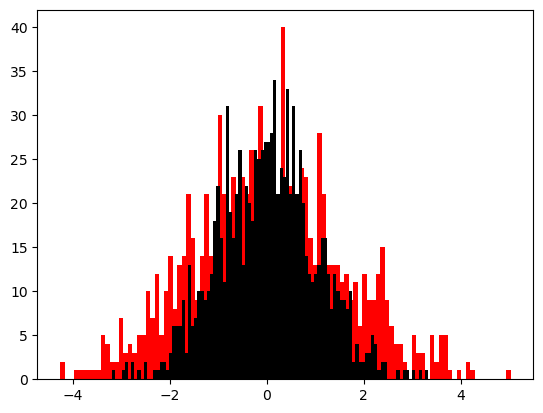

In [60]:
import matplotlib.pyplot as plt
plt.hist(samples2, bins=100, color="red")
plt.hist(samples1, bins=100, color="black")
plt.show

In [4]:
samples1

array([ 0.58840068, -0.45364759, -0.82995496, ..., -0.10594143,
       -0.50003768, -0.70481669])